# Part 10: Доведем модель на базе FixEfficientNetB0 до максимальных показателей.
- Применим оптимальные полученные комбинации аугментации, batch и dropout нормализации.
- Применим оптимальные полученные комбинации аугментации.
- Применим файн тюнинг.
- Уменьшим степень аугментации в конце обучения.
- Добавим Test Time Augmentation (TTA).

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf

config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
import efficientnet.tfkeras as efn
from tensorflow.keras.layers import *
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
Numpy        : 1.19.4
Tensorflow   : 2.4.0
Keras        : 2.4.0


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!pip freeze > requirements.txt

## Основные настройки

In [5]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS = 10  # эпох на обучение
BATCH_SIZE = 16  # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR = 0.001 # lerning rate
VAL_SPLIT = 0.15  # сколько данных выделяем на тест = 15%

CLASS_NUM = 10  # количество классов в нашей задаче
IMG_SIZE = 224  # какого размера подаем изображения в сеть
IMG_CHANNELS = 3   # у RGB 3 канала
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

part = 'part_10'  # Версия эксперимента

In [6]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

In [7]:
# Графики
def make_graf(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

## EDA / Анализ данных

In [8]:
train_df = pd.read_csv("data/train.csv")
sample_submission = pd.read_csv("data/sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [10]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение классов достаточно равномерное — это хорошо.

In [11]:
# print('Распаковываем картинки')
# # Will unzip the files so that you can see them..
# for data_zip in ['train.zip', 'test.zip']:
#     with zipfile.ZipFile("data/"+data_zip, "r") as z:
#         z.extractall('data/')

# print(os.listdir('data/'))

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

Пример картинок (random sample)


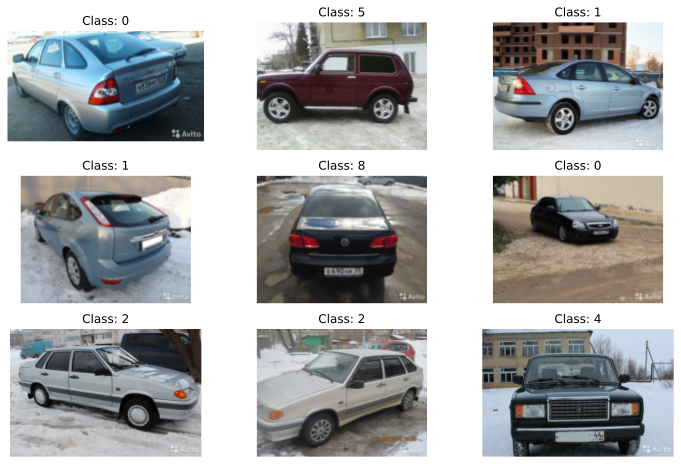

In [12]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(f'data/train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')

plt.show()

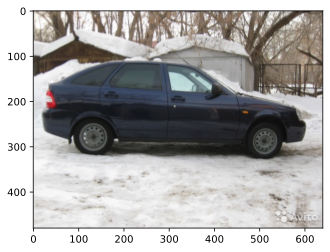

(640, 480)

In [13]:
image = PIL.Image.open('data/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

## Подготовка данных
### Аугментация данных

In [14]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.8),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.7),
    albumentations.Blur(blur_limit=3, always_apply=False, p=0.5),
    albumentations.HueSaturationValue(
        hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.7),
    albumentations.RGBShift(r_shift_limit=20, g_shift_limit=20,
                            b_shift_limit=20, always_apply=False, p=0.7),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.ChannelShuffle(p=0.7),
    albumentations.CLAHE(clip_limit=3.0, tile_grid_size=(
        8, 8), always_apply=False, p=0.3),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

test_datagen = ImageDataAugmentor(rescale=1./255)

### Генерация данных

In [15]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    'data/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    'data/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory='data/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Посмотрим результат

Пример картинок из train_generator


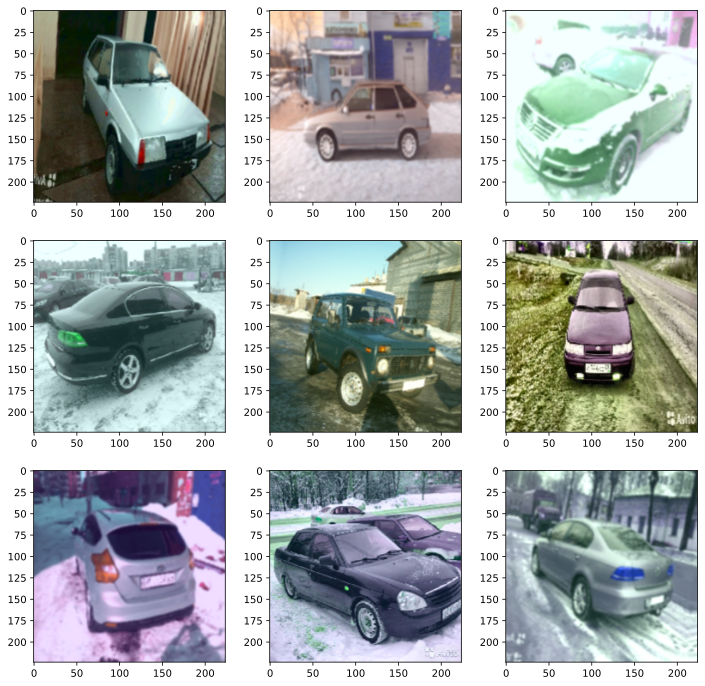

In [16]:
from skimage import io
 
def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()
 
x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,12))
 
for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

## Построение модели
### Загружаем предобученную сеть Xception

In [17]:
base_model = efn.EfficientNetB0(
    weights='imagenet', include_top=False, input_shape=input_shape)

Замораживаем веса

In [18]:
# first: train only the top layers (which were randomly initialized)
base_model.trainable = False

Строим модель

In [19]:
# Устанавливаем новую "голову" (head)
x = base_model.output

# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)

# x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

## Обучение модели
Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [17]:
checkpoint = ModelCheckpoint('best_model_{}.hdf5'.format(
    part), monitor=['val_accuracy'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

### Обучаем

In [21]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/10
827/827 [==============================] - 201s 235ms/step - loss: 1.5613 - accuracy: 0.4357 - val_loss: 1.0437 - val_accuracy: 0.6226

Epoch 00001: saving model to best_model_part_10.hdf5
Epoch 2/10
827/827 [==============================] - 196s 237ms/step - loss: 1.0407 - accuracy: 0.6244 - val_loss: 0.8490 - val_accuracy: 0.6917

Epoch 00002: saving model to best_model_part_10.hdf5
Epoch 3/10
827/827 [==============================] - 208s 251ms/step - loss: 0.9198 - accuracy: 0.6605 - val_loss: 0.8308 - val_accuracy: 0.6977

Epoch 00003: saving model to best_model_part_10.hdf5
Epoch 4/10
827/827 [==============================] - 203s 245ms/step - loss: 0.8790 - accuracy: 0.6819 - val_loss: 0.8200 - val_accuracy: 0.7110

Epoch 00004: saving model to best_model_part_10.hdf5
Epoch 5/10
827/827 [==============================] - 199s 241ms/step - loss: 0.8284 - accuracy: 0.6965 - val_loss: 0.7955 - val_accuracy: 0.7029

Epoch 00005: saving model to best_model_part_10.hdf5


In [22]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

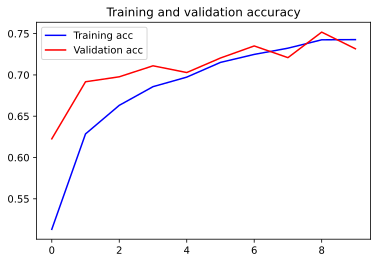

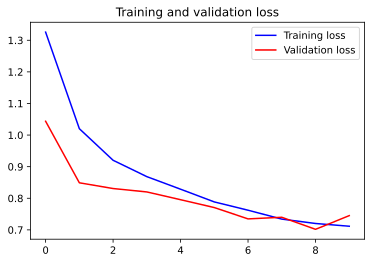

In [23]:
# Графики
make_graf(history)

Посмотрим сколько слоев в имиджнет модели

In [25]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  230


Размораживаем имиджнет-модель частично (44 слоя размораживаем, 88 оставляем замороженными)

In [26]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 88

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Уменьшаем learning rate

In [27]:
LR=0.0005
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Увеличиваем колиечество эпох обучения, т. к. уменьшили learnig rate

In [28]:
EPOCHS = 15
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/15
827/827 [==============================] - 219s 254ms/step - loss: 1.0507 - accuracy: 0.6623 - val_loss: 0.5225 - val_accuracy: 0.8338

Epoch 00001: saving model to best_model_part_10.hdf5
Epoch 2/15
827/827 [==============================] - 213s 258ms/step - loss: 0.4182 - accuracy: 0.8541 - val_loss: 0.3595 - val_accuracy: 0.8854

Epoch 00002: saving model to best_model_part_10.hdf5
Epoch 3/15
827/827 [==============================] - 219s 265ms/step - loss: 0.3406 - accuracy: 0.8837 - val_loss: 0.3351 - val_accuracy: 0.8888

Epoch 00003: saving model to best_model_part_10.hdf5
Epoch 4/15
827/827 [==============================] - 220s 266ms/step - loss: 0.2573 - accuracy: 0.9088 - val_loss: 0.3364 - val_accuracy: 0.8978

Epoch 00004: saving model to best_model_part_10.hdf5
Epoch 5/15
827/827 [==============================] - 219s 264ms/step - loss: 0.2325 - accuracy: 0.9202 - val_loss: 0.3364 - val_accuracy: 0.8944

Epoch 00005: saving model to best_model_part_10.hdf5


In [29]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

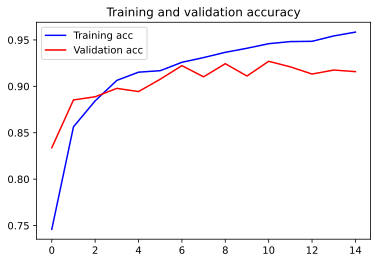

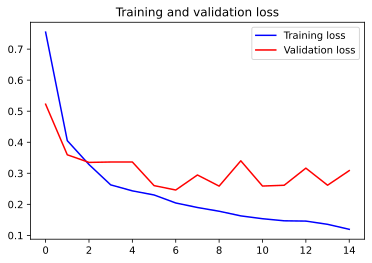

In [30]:
# Графики
make_graf(history)

Еще размораживаем имиджнет-модель частично (44 слоя размораживаем, 44 оставляем замороженными)

In [32]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 44

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Еще уменьшаем learning rate

In [33]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Еще увеличиваем колиечество эпох обучения

In [34]:
EPOCHS = 20
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/20
827/827 [==============================] - 226s 262ms/step - loss: 0.0995 - accuracy: 0.9635 - val_loss: 0.2097 - val_accuracy: 0.9395

Epoch 00001: saving model to best_model_part_10.hdf5
Epoch 2/20
827/827 [==============================] - 217s 262ms/step - loss: 0.0622 - accuracy: 0.9783 - val_loss: 0.2137 - val_accuracy: 0.9420

Epoch 00002: saving model to best_model_part_10.hdf5
Epoch 3/20
827/827 [==============================] - 218s 263ms/step - loss: 0.0507 - accuracy: 0.9807 - val_loss: 0.2455 - val_accuracy: 0.9377

Epoch 00003: saving model to best_model_part_10.hdf5
Epoch 4/20
827/827 [==============================] - 219s 265ms/step - loss: 0.0446 - accuracy: 0.9842 - val_loss: 0.2381 - val_accuracy: 0.9395

Epoch 00004: saving model to best_model_part_10.hdf5
Epoch 5/20
827/827 [==============================] - 232s 280ms/step - loss: 0.0370 - accuracy: 0.9872 - val_loss: 0.2251 - val_accuracy: 0.9455

Epoch 00005: saving model to best_model_part_10.hdf5


In [35]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

Окончательно размораживаем имиджнет-модель

In [37]:
base_model.trainable = True

Еще уменьшаем learning rate

In [38]:
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Еще увеличиваем колиечество эпох обучения

In [39]:
EPOCHS = 25
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/25
827/827 [==============================] - 293s 343ms/step - loss: 0.0282 - accuracy: 0.9901 - val_loss: 0.2203 - val_accuracy: 0.9558

Epoch 00001: saving model to best_model_part_10.hdf5
Epoch 2/25
827/827 [==============================] - 277s 335ms/step - loss: 0.0311 - accuracy: 0.9908 - val_loss: 0.2321 - val_accuracy: 0.9511

Epoch 00002: saving model to best_model_part_10.hdf5
Epoch 3/25
827/827 [==============================] - 281s 340ms/step - loss: 0.0273 - accuracy: 0.9891 - val_loss: 0.2186 - val_accuracy: 0.9553

Epoch 00003: saving model to best_model_part_10.hdf5
Epoch 4/25
827/827 [==============================] - 277s 335ms/step - loss: 0.0220 - accuracy: 0.9928 - val_loss: 0.2310 - val_accuracy: 0.9519

Epoch 00004: saving model to best_model_part_10.hdf5
Epoch 5/25
827/827 [==============================] - 285s 345ms/step - loss: 0.0154 - accuracy: 0.9946 - val_loss: 0.2127 - val_accuracy: 0.9528

Epoch 00005: saving model to best_model_part_10.hdf5


In [40]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

### Оценим метрику

In [42]:
scores = model.evaluate_generator(
    test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 30s 207ms/step - loss: 0.2236 - accuracy: 0.9528
Accuracy: 95.28%


### Step 2: Уменьшим значения аугментации, увеличим размер изображения

In [19]:
BATCH_SIZE = 4  # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
IMG_SIZE = 512  # какого размера подаем изображения в сеть
IMG_CHANNELS = 3   # у RGB 3 канала
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
LR=0.00001

In [20]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.8),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [21]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    'data/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    'data/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory='data/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Т. к. изменился input_shape, необходимо заново создать сеть

In [22]:
base_model = efn.EfficientNetB0(
    weights='imagenet', include_top=False, input_shape=input_shape)

In [23]:
# Устанавливаем новую "голову" (head)
x = base_model.output

# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)

# x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Подгружаем веса

In [24]:
model.load_weights('2-best_model_part_10.hdf5')

Обучаем

In [25]:
EPOCHS = 10
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/10
3308/3308 [==============================] - 1308s 390ms/step - loss: 0.7956 - accuracy: 0.7396 - val_loss: 0.2040 - val_accuracy: 0.9382

Epoch 00001: saving model to best_model_part_10.hdf5
Epoch 2/10
3308/3308 [==============================] - 1373s 415ms/step - loss: 0.2464 - accuracy: 0.9216 - val_loss: 0.1506 - val_accuracy: 0.9562

Epoch 00002: saving model to best_model_part_10.hdf5
Epoch 3/10
3308/3308 [==============================] - 1428s 432ms/step - loss: 0.1689 - accuracy: 0.9426 - val_loss: 0.1439 - val_accuracy: 0.9592

Epoch 00003: saving model to best_model_part_10.hdf5
Epoch 4/10
3308/3308 [==============================] - 1429s 432ms/step - loss: 0.1284 - accuracy: 0.9576 - val_loss: 0.1294 - val_accuracy: 0.9674

Epoch 00004: saving model to best_model_part_10.hdf5
Epoch 5/10
3308/3308 [==============================] - 1444s 436ms/step - loss: 0.1073 - accuracy: 0.9639 - val_loss: 0.1315 - val_accuracy: 0.9657

Epoch 00005: saving model to best_mode

In [26]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

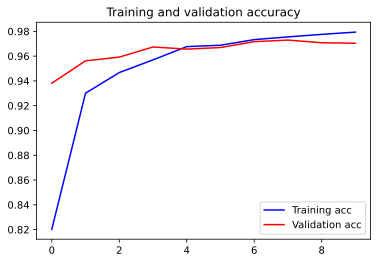

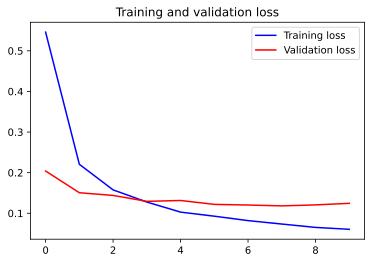

In [27]:
# Графики
make_graf(history)

**Оценим метрику**

In [29]:
scores = model.evaluate_generator(
    test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 62s 106ms/step - loss: 0.1182 - accuracy: 0.9708
Accuracy: 97.08%


### Предсказание на тестовых данных

In [30]:
test_sub_generator.samples

6675

In [31]:
test_sub_generator.reset()
predictions = model.predict_generator(
    test_sub_generator, steps=len(test_sub_generator), verbose=1)
predictions = np.argmax(predictions, axis=-1)  # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

1669/1669 [==============================] - 181s 108ms/step


In [32]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')
submission.to_csv('submission_{}.csv'.format(part), index=False)
print('Save submit')

Save submit


In [33]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


### Step 3: ТТА (Test Time Augmentation)

In [35]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.8),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.7),
    albumentations.Blur(blur_limit=3, always_apply=False, p=0.5),
    albumentations.HueSaturationValue(
        hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.7),
    albumentations.RGBShift(r_shift_limit=20, g_shift_limit=20,
                            b_shift_limit=20, always_apply=False, p=0.7),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.ChannelShuffle(p=0.7),
    albumentations.CLAHE(clip_limit=3.0, tile_grid_size=(
        8, 8), always_apply=False, p=0.3),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

Работаем с тестовым датасетом

In [36]:
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [37]:
test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory='data/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 6675 validated image filenames.


In [38]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

1669/1669 [==============================] - 333s 199ms/step


In [39]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [40]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv(f'submission_TTA_{part}.csv', index=False)
print('Save submit')

Save submit


### Вывод по данной части работы:
- Метрика на тесте: 97.08%
- Метрика на Kaggle: 96.808%
- Метрика с ТТА: 97.243%

### Выводы по проекту:
- Протестировал различные комбинации слоев dropout и batch нормализации.
- Протестировал различные комбинации полносвязных слоев и количество нейронов в слоях.
- Протестировал различные параметры аугментации.
- Протестировал влияние значения learnin rate на качество обучения модели.
- Применил callbacks функцию для сохранения лучших параметров модели и остановки обучения, когда модель перестает обучаться.
- Протестировал влияние количества эпох обучения на качество обучения модели.
- Разобрался с распределением ресурсов ПК между CPU с оперативной памятью и GPU. Существенно улучшил производительность процесса.
- Протестировал имиджнет-модели - Xception, FixEfficientNetB7, FixEfficientNetB0.
- Применил файн тюнинг при обучении модели.
- Добавил Test Time Augmentation (TTA).
- Сделал web-сервис, предсказывающий модель авто по загружаемому изображению.
- Увеличил точность предсказания модели до 97.243%.